# Empirical exploration of linear classifiers

In this lab session we are going to explore binary classification with 2 linear classifiers:

### The Rosenblatt perceptron (1958)
<img src="../data/perceptron_a.png" alt="perceptron unit" style="width: 200px;"/>

The perceptron algorithm was proposed by Rosenblatt in 1958. It is inspired by the biological neuron cell. The perceptron is described by:
- Input: $\mathbf{x}=(x_1,\ldots,x_d)\in\mathbb{R}^d$ 
- Output: $t\in\{-1,1\}$
- Parameters: $\mathbf{w}=(w_1,\ldots,w_d)\in\mathbb{R}^d$ and $w_0\in\mathbb{R}$
- 2 steps:
  + integration: $f(\mathbf{x})=\mathbf{w}\cdot \mathbf{x} + w_0 = W_0 + \sum_{r=1}^d w_r x_r$
  + transfer: $g\circ f(\mathbf{x}) = \textrm{sign}(f(\mathbf{x}))$

The perceptron training algorithm goes as follows:
- Input: A training set $S = \{(\mathbf{x}_1, t_1), \ldots,(\mathbf{x}_m, t_m)\}$
- Initialization: $l=0$, $\mathbf{w}^{(l)}=(0,\ldots,0), \> w_0^{(l)}=0$
- Until convergence or reaching a specified l=L:
  + if $\exists i\in\{1,\ldots,m\}\quad s.t.\quad (\mathbf{w}^{(l)} \cdot \mathbf{x}_i + w_0^{(l)}) t_i \leq 0$ then
  + Update: $\mathbf{w}^{(l+1)}=\mathbf{w}^{(l)}+t_i\mathbf{x}_i$ and $w_0^{(l+1)}=w_0^{(l)}+t_i$

In the separable case the perceptron algorithm is guarantee to converge. In the non-separable case one has to set a maximal number of iterations (to perform early stopping).

The perceptron returns a linear classifier that divides the domain in two halfspaces along the affine boundary with equation $f(\mathbf{x})=\mathbf{w}\cdot \mathbf{x} + w_0 = 0$. 


### Logistic regression
The *sigmoid* function $\sigma:\mathbb{R}\rightarrow ]0,1[$ is defined by: $$\sigma(z)=\frac{1}{1+e^{-z}}$$

In the logistic regression model we learn an hypothesis of the form: $$h(\mathbf{x})=\sigma(\mathbf{w}\cdot \mathbf{x}+w_0)$$ which can be interpreted as the *probability* that $\mathbf{x}$ is labeled 1, 
$$\sigma(\mathbf{w}\cdot \mathbf{x}+w_0) = P(y=1|\mathbf{x}).$$

The maximum likelihood estimates of $\mathbf{w}, w_0$ can be obtained with the Iterative reweighted least squares (IRLS) algorithm (see Bishop p. 207)



In [152]:
import numpy as np
from numpy import linalg as la

In [153]:
class Perceptron:
    def __init__(self, max_iter=1):
        self.max_iter = max_iter
        self.weights = np.zeros(2)
        self.bias = 0
        self.dim = -1
    
    def fit(self,X, y):
        "Assumes X is a mxdim matrix and y is a vector of m values in {-1,1}"  
        change = True
        nb_iter = 0
        while change == True and self.max_iter > nb_iter:
            change = False
            for i in range(len(y)):
                if y[i]*(self.weights.dot(X[i])+self.bias) <= 0:
                    self.weights = self.weights + y[i]*X[i]
                    self.bias = self.bias + y[i]
                    change = True
            nb_iter = nb_iter +1 
        
    def predict(self,X):
        "Assumes the model was fitted a first time"
        return np.sign(self.weights.dot(X.transpose())+self.bias)

In [154]:
class Logistic_Regression:
    def __init__(self, max_iter=50, eps_conv=0.9):
        self.max_iter = max_iter
        self.eps_conv = eps_conv # If too small risk of breaking
        self.weights = np.zeros(2) 
        self.bias = np.zeros(1)
        self.dim = -1
    
    def fit(self,X, y):
        "Assumes X is a mxdim matrix and y is a vector of m values in {0,1}"
        
        #To add the bias as a parameter, I add the bias inside w_old and add a one inside X.

        m = X.shape[0]
        dim = X.shape[1]
        self.dim = dim
        #initialisation : 1 iteration of IRLS algorithm
        w = np.zeros(dim)

        "My modifications"
        w_old = np.hstack((self.bias, w))
        X_prime = np.hstack((np.ones((m, 1)), X))
        y_pred = 1/2*np.ones((m,))
        R = np.diag(y_pred*(1-y_pred))   # diag(y_n(1-y_n))
        z = X_prime.dot(w_old)-la.inv(R).dot(y_pred-y)
        w = la.inv(X_prime.T.dot(R).dot(X_prime)).dot(X_prime.T).dot(R).dot(z)
        
        # Newton-Raphson algorithm 
        Niter = 1
        while ( (la.norm(w-w_old)/la.norm(w)>self.eps_conv) and (Niter<self.max_iter) ):
            Niter = Niter+1
            y_pred = 1/(1+np.exp(-X_prime.dot(w)))
            R = np.diag(y_pred*(1-y_pred))  
            w_old = w
            z = X_prime.dot(w_old)-la.inv(R).dot(y_pred-y) 
            w = la.inv(X_prime.T.dot(R).dot(X_prime)).dot(X_prime.T).dot(R).dot(z)

        print("Solution found after", Niter, "iterations.")
        self.weights = w
        
    def predict_proba(self,X):
        "Returns the probability of class 1 for each example. Assumes the model was fitted a first time"
        # Modifying the X for this method*
        m = X.shape[0]
        X_prime = np.hstack((np.ones((m, 1)), X))
        proba = 1/(1+np.exp(-X_prime.dot(self.weights)))
        return proba 
    
    def predict(self,X):
        "Returns the predicted label for each example. Assumes the model was fitted a first time"
        m = X.shape[0]
        X_prime = np.hstack((np.ones((m, 1)), X))
        proba = 1/(1+np.exp(-X_prime.dot(self.weights)))
        return [1 if proba > 0.5 else 0 for proba in proba]

## iris Data
![3 differents iris species](../data/iris-machinelearning.png)

### Load the data
It is a classical toy example, hence it is included in scikit-learn package.

In [155]:
from sklearn import datasets
iris = datasets.load_iris()

iris is a dictionary with the following keys:

In [156]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [157]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [158]:
import pandas as pd
X = pd.DataFrame(iris.data, columns=['sepal length','sepal width', 'petal length','petal width'])
y = pd.Series(iris.target)

Just for some test

In [159]:
import numpy as np
X_prime = np.hstack((np.ones((X.shape[0], 1)), X))

w = np.zeros(X.shape[1])
w_prime = np.hstack((np.ones(1), w))

<Axes: xlabel='sepal width', ylabel='petal length'>

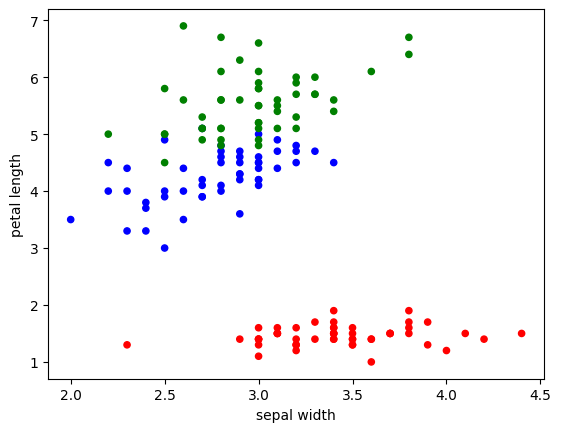

In [160]:
%matplotlib inline
col = {0:"r", 1:"b", 2:"g"}
X.plot.scatter(x="sepal width", y="petal length", c=[col[e] for e in y])

## Questions
> ### Questions:
> 0. Code the perceptron algorithm defined above in the python class below. 
> 1. Modify the fit method of the Logistic_Regression class in order for it to fit also a bias $w_0$ parameter. (HINT: np.hstack and np.ones might be very handy)
> 1. Modify the predict_proba method accordingly and complete the predict method.  
> 1. What is the input domain of the Iris dataset?
> 1. Consider only 2 dimensions (e.g. 'sepal width', 'petal length'): visualise the dataset and the classes
> 1. Recode the classes to get a binary classification problem :
>    * Iris setosa : Class 2
>    * Iris Versicolor & Iris Virginica : Class 1
> 1. Use the coded perceptron and logistic regression to separate the 2 classes Compute the empirical and generalization errors. Visualize the decision functions (use the weights $w$). Comment.
> 1. Recode the classes
>    * Iris Virginica : Class 2
>    * Iris Setosa & Iris Versicolor : Class 1
>    and repeat the previous question for this classification problem. Comment.
> 1. Compare the time complexity of one step of each algorithm. 
> 1. Upload the eggyoke datasets. Use the perceptron and the logistic regression algorithms to solve the classification problem. Compute the empirical and generalization errors. Visualize the decision function (use the weights $w$). What happens? What could be done?

**Question 0 :**
        I fill the empty part adding the part of the code missing for fitting of the weights.


**Question 1 :**
        To add the bias into the fit method of my Logistic_regression algorithm. I add the bias at the first element of my weights and add a one inside my input array.

**Question 2**

In [161]:
model = Logistic_Regression(eps_conv=0.9725)
model.fit(X.values, y)

Solution found after 2 iterations.


**Question 3 :** What is the input domain of the Iris dataset?

In [162]:
# X : the features 
# y : the labels
 
for cols in X:
    print("Column :" + cols)
    print("max : " + str(X[cols].max()) + ", min : " + str(X[cols].min()))

Column :sepal length
max : 7.9, min : 4.3
Column :sepal width
max : 4.4, min : 2.0
Column :petal length
max : 6.9, min : 1.0
Column :petal width
max : 2.5, min : 0.1


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

We can see so the input domain of the dataset iris is :

$$D = [4.3, 7.9] \times [2, 4.4] \times [1, 6.9] \times [0.1, 2.5]$$
</div>

**Question 4 :** Consider only 2 dimensions (e.g. 'sepal width', 'petal length'): visualise the dataset and the classes
    This new dataset will assign to a value "y" 2 features instead of 4 in the original dataset.

In [163]:
df_2D = pd.DataFrame(X[["sepal width", "petal length"]])
df_visu = df_2D.copy()
df_visu["Class"] = y
df_visu

,sepal width,petal length,Class
0,3.5,1.4,0
1,3.0,1.4,0
2,3.2,1.3,0
3,3.1,1.5,0
4,3.6,1.4,0
...,...,...,...
145,3.0,5.2,2
146,2.5,5.0,2
147,3.0,5.2,2
148,3.4,5.4,2


**Question 5 :** Recode the classes to get a binary classification problem :

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

We already know, that Iris setosa = 0 and the 2 other are equal to 1 and 2.
- For the perceptron case, we will need to have 2 class, -1 and 1.
- For the regression case, we will need 0 and 1.

</div>

In [164]:
y_bin = y.replace(2, 1)
y_bin = y_bin.replace(0, -1)

**Question 6 :** Use the coded perceptron and logistic regression to separate the 2 classes Compute the empirical and generalization errors. Visualize the decision functions (use the weights $w$). Comment.

In [165]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_2D, y_bin, test_size=0.2, shuffle=True, random_state=30)

**Perceptron**

In [166]:
from sklearn.metrics import hinge_loss, zero_one_loss

model_perc = Perceptron(max_iter=10)
print("Weights pre-training", model_perc.weights, "bias pre-training", model_perc.bias)
model_perc.fit(X_train.to_numpy(), y_train.values)
print("Weights pre-training", model_perc.weights, "bias post-training", model_perc.bias)
y_pred_perc = model_perc.predict(X_test)

Weights pre-training [0. 0.] bias pre-training 0
Weights pre-training [-5.3  5.4] bias post-training -1


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

We know the error is compute like : $L(y^i, \hat{y}^i)$. In our perceptron case we will use the hinge loss for the empirical error and the 0/1 loss as a generalization function.  
**The empirical loss** using the hinge loss : 
$$\hat{\mathcal{E}}_{\text{Hinge}} = \frac{1}{N_{\text{train}}} \sum_{i=1}^{N_{\text{train}}} \max \left(0, 1 - t_i g(f(x_i)) \right)$$
with $t$ the expected value and $g(f(x))$ the predicted value. *(Can't use the cross-entropy loss because of the labels {-1, 1})*  
**The generalization error** using the 0/1 loss : 
$$\hat{\mathcal{E}}_{\text{Généralisation}} = \frac{1}{N_{\text{test}}} \sum_{j=1}^{N_{\text{test}}} \mathbb{I}(g(f(x_j)) \ne t_j)$$

</div>

In [167]:
empirical_error = hinge_loss(model_perc.predict(X_train), y_train)
generalization_error = zero_one_loss(y_pred_perc, y_test)

print("empirical_error", empirical_error)
print("generalization_error", generalization_error)

empirical_error 0.0
generalization_error 0.0


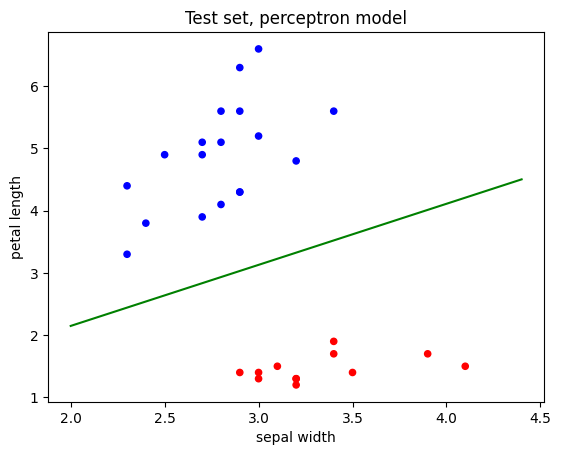

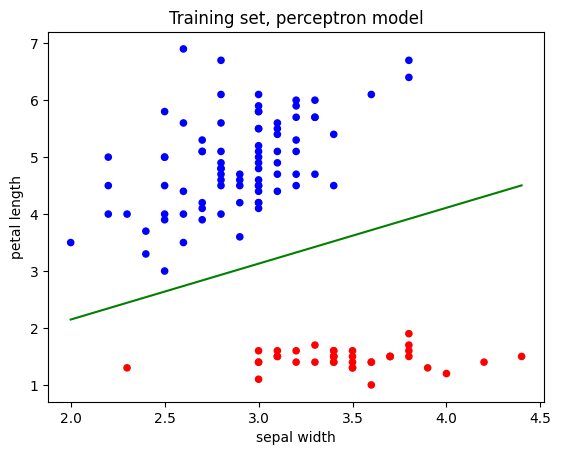

In [168]:
%matplotlib inline

col = {-1:"r", 1:"b"}
ax = X_test.plot.scatter(x="sepal width", y="petal length", c=[col[e] for e in y_pred_perc])
ax.set_title("Test set, perceptron model")

bx = X_train.plot.scatter(x="sepal width", y="petal length", c=[col[e] for e in model_perc.predict(X_train)])
bx.set_title("Training set, perceptron model")

x1 = np.linspace(2, 4.4, 100)
def f(x1):
    b = model_perc.bias
    w1 = model_perc.weights[0]
    w2 = model_perc.weights[1]
    x2 = - (b + w1*x1) / w2
    return x2
    
ax.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')
bx.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

The perceptron returns a linear classifier that divides the domain in two halfspaces along the affine boundary with equation $f(\mathbf{x})=\mathbf{w}\cdot \mathbf{x} + w_0 = 0$, so $$P(y=0|x) = P(y=1|x) = 0.5$$

And this classifier work in two steps : 
-  $$f(x) = w \times x + w_0$$
-  $$ h(x) = g(f(x)) = sign(f(x))$$

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

The equation of the boundary line separating the data space in two halfspace is : 
$$ f(\bold{x}) = \bold{w} \times \bold{x} + b = 0$$
So for each point of the absis I can compute : 
$$ w_1 \times x_1 + w_2 \times x_2 + b = 0 \Leftrightarrow w_2 \times x_2 = - (w_1 \times x_1) - b $$
$$ \Leftrightarrow x_2 = \frac{- (w_1 \times x_1 + b)}{w_2}$$

So because g(x) is the sign function we have : 
$$ f(x) > 0 \Leftrightarrow g(f(x)) = 1$$
$$ f(x) < 0 \Leftrightarrow g(f(x)) = -1$$
After this, we have to choose in the case $f(x) = 0$ (so x is on the boundary line) if we want to classify in 1 or 2.
Such that : $h(x) = -1$ means $x \in c_1$ and $h(x) = 1$ means $x \in c_2$

**Regression**

In [169]:
y_train_reg = y_train.replace(-1, 0)
y_test_reg = y_test.replace(-1, 0)

In [170]:
from sklearn.metrics import log_loss, zero_one_loss

log_regress = Logistic_Regression(eps_conv=0.15)
print("Weights pre-training", log_regress.weights, "bias", log_regress.bias)
log_regress.fit(X_train.to_numpy(), y_train_reg.values)
print("Weights pre-training", log_regress.weights)
y_pred_reg = log_regress.predict(X_test)

Weights pre-training [0. 0.] bias [0.]
Solution found after 8 iterations.
Weights pre-training [ 0.30500776 -5.40588757  5.79458591]


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">


Same principle as the perceptron.  
**The empirical loss** using the cross entropy loss (because evaluate on the probability): 
$$\mathcal{L}_{\text{log}} = - \frac{1}{N_{\text{Train}}} \sum_{i=1}^{N_{\text{Train}}}  t_i \times h(x_i) + (1 - t_i)\log(1-h(x_i)$$
with $t$ the expected value and $h(x_i)$ the predicted probability.  
**The generalization error** using the 0/1 loss : 
$$\hat{\mathcal{E}}_{\text{Généralisation}} = \frac{1}{N_{\text{test}}} \sum_{j=1}^{N_{\text{test}}} \mathbb{I}(h(x_j) \ne t_j)$$

In [171]:
empirical_error = log_loss(y_train_reg, log_regress.predict_proba(X_train))
generalization_error = zero_one_loss(y_pred_reg, y_test_reg)

print("empirical_error", empirical_error)
print("generalization_error", generalization_error)

empirical_error 0.00034557452562455085
generalization_error 0.0


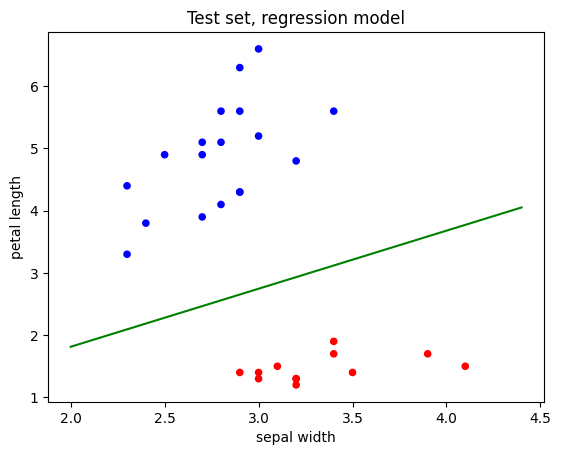

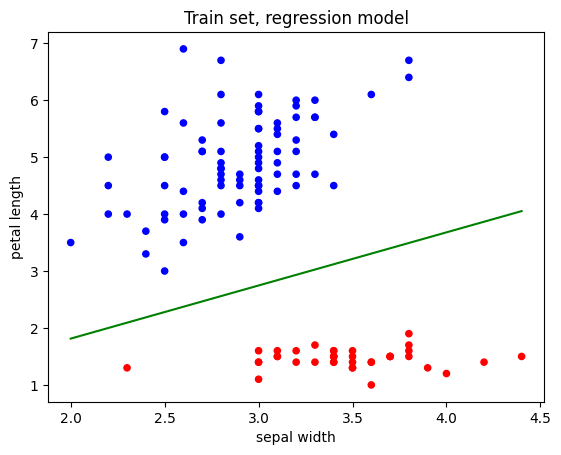

In [172]:
%matplotlib inline

col = {0:"r", 1:"b"}
ax = X_test.plot.scatter(x="sepal width", y="petal length", c=[col[e] for e in y_pred_reg])
ax.set_title("Test set, regression model")

bx = X_train.plot.scatter(x="sepal width", y="petal length", c=[col[e] for e in log_regress.predict(X_train)])
bx.set_title("Train set, regression model")

x1 = np.linspace(2, 4.4, 100)
def f(x1):
    b = log_regress.weights[0]
    w1 = log_regress.weights[1]
    w2 = log_regress.weights[2]
    x2 = - (b + w1*x1) / w2
    return x2

ax.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')
bx.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

In the logistic regression model we learn an hypothesis of the form: $$h(\mathbf{x})=\sigma(\mathbf{w}\cdot \mathbf{x}+w_0)$$ which can be interpreted as the *probability* that $\mathbf{x}$ is labeled 1, 
$$\sigma(\mathbf{w}\cdot \mathbf{x}+w_0) = P(y=1|\mathbf{x}).$$
Because we are in binary classification we know : 
$$ P(y=1|\mathbf{x}) + P(y=0|\mathbf{x}) = 1.$$

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

Knowing this, the equation of the boundary line can be represente as : $P(y=1|x) = P(y=0|x)$.
$$P(y=1|x) + P(y=0|x) = 1 \Leftrightarrow P(y=1|x) = P(y=0|x) = 0.5$$
So we can represent the boundary function like : 
$$\sigma(\mathbf{w}\cdot \mathbf{x}+w_0) = 0.5 \Leftrightarrow \frac{1}{1 + \exp^{-(\bold{w} \times \bold{x} + b)}} = 0.5$$
$$\frac{1}{1 + \exp^{-(w_1 \times x_1 + w_2 \times x_2 + b)}} = 0.5 \Leftrightarrow 1 + \exp^{-(w_1 \times x_1 + w_2 \times x_2 + b)} = 2 $$
$$\exp^{-(w_1 \times x_1 + w_2 \times x_2 + b)} = 1 \Leftrightarrow w_1 \times x_1 + w_2 \times x_2 + b = 0$$
So each point of the boundary function can be compute like : 
$$ w_1 \times x_1 + w_2 \times x_2 + b = 0 \Leftrightarrow w_2 \times x_2 = - (w_1 \times x_1) - b = 0$$
$$ \Leftrightarrow x_2 = \frac{- (w_1 \times x_1 + b)}{w_2}$$

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

So our linear regression model classify point using the sigmoid function. If $\sigma(\mathbf{w}\cdot \mathbf{x}+w_0) > 0$, this means $P(y=1|\mathbf{x}) > 1$ so we will classify our point x as $y=1$. In the other case it will be $y=0$.
Knowing our data are very separable, the empirical and generalization error being equal to 0 is not surprising.

**Question 7 :**
Recode the classes
>    * Iris Virginica : Class 2
>    * Iris Setosa & Iris Versicolor : Class 1
>    and repeat the previous question for this classification problem. Comment.

In [173]:
from sklearn.model_selection import train_test_split
y_recode = y.replace(0, 1)

X_train, X_test, y_train, y_test = train_test_split(df_2D, y_recode, test_size=0.2, shuffle=True, random_state=20)

**Perceptron**

In [174]:
from sklearn.metrics import hinge_loss, zero_one_loss

y_train_for_perc = y_train.replace(1, -1)
y_train_for_perc = y_train_for_perc.replace(2, 1)

y_test_for_perc = y_test.replace(1, -1)
y_test_for_perc = y_test_for_perc.replace(2, 1)

model_perc = Perceptron(max_iter=20)
print("Weights pre-training", model_perc.weights, "bias pre-training", model_perc.bias)
model_perc.fit(X_train.to_numpy(), y_train_for_perc.values)
print("Weights pre-training", model_perc.weights, "bias post-training", model_perc.bias)
y_pred_perc = model_perc.predict(X_test)

Weights pre-training [0. 0.] bias pre-training 0
Weights pre-training [-29.5  25. ] bias post-training -39


In [175]:
empirical_error = hinge_loss(model_perc.predict(X_train), y_train_for_perc)
generalization_error = zero_one_loss(y_pred_perc, y_test_for_perc)

print("empirical_error", empirical_error)
print("generalization_error", generalization_error)

empirical_error 0.18333333333333332
generalization_error 0.033333333333333326


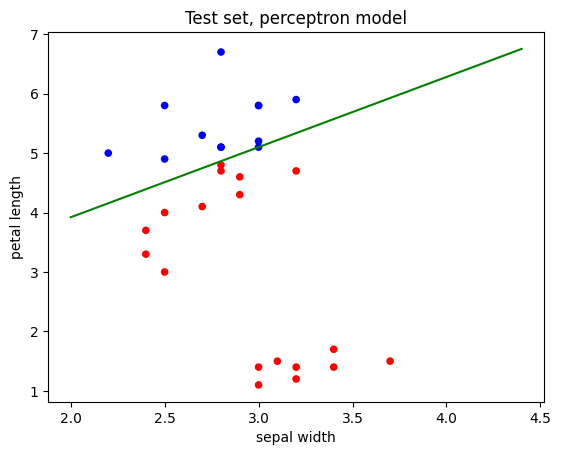

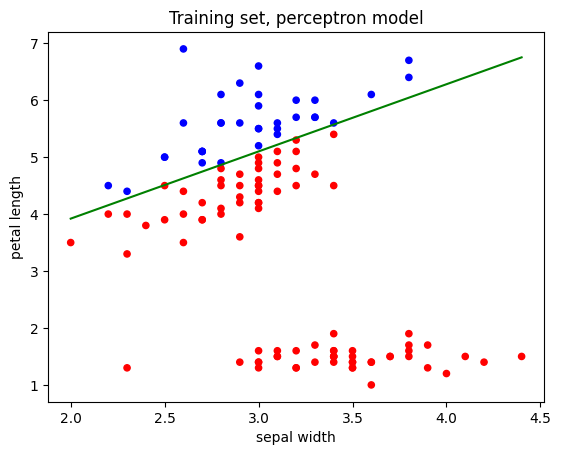

In [176]:
%matplotlib inline

col = {-1:"r", 1:"b"}
ax = X_test.plot.scatter(x="sepal width", y="petal length", c=[col[e] for e in y_pred_perc])
ax.set_title("Test set, perceptron model")

bx = X_train.plot.scatter(x="sepal width", y="petal length", c=[col[e] for e in model_perc.predict(X_train)])
bx.set_title("Training set, perceptron model")

x1 = np.linspace(2, 4.4, 100)
def f(x1):
    b = model_perc.bias
    w1 = model_perc.weights[0]
    w2 = model_perc.weights[1]
    x2 = - (b + w1*x1) / w2
    return x2
    
ax.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')
bx.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')

**Regression**

In [177]:
y_train_for_regress = y_train_for_perc.replace(-1, 0)
y_test_for_regress = y_test_for_perc.replace(-1, 0)

In [178]:
log_regress = Logistic_Regression(eps_conv=0.01)
print("Weights pre-training", log_regress.weights, "bias", log_regress.bias)
log_regress.fit(X_train.to_numpy(), y_train_for_regress.values)
print("Weights pre-training", log_regress.weights)
y_pred_reg = log_regress.predict(X_test)

Weights pre-training [0. 0.] bias [0.]
Solution found after 9 iterations.
Weights pre-training [-32.97732059  -3.47988028   8.8955347 ]


In [179]:
from sklearn.metrics import log_loss, zero_one_loss

empirical_error = log_loss(y_train_for_regress, log_regress.predict(X_train))
generalization_error = zero_one_loss(y_pred_reg, y_test_for_regress)

print("empirical_error", empirical_error)
print("generalization_error", generalization_error)

empirical_error 1.5018188912132149
generalization_error 0.033333333333333326


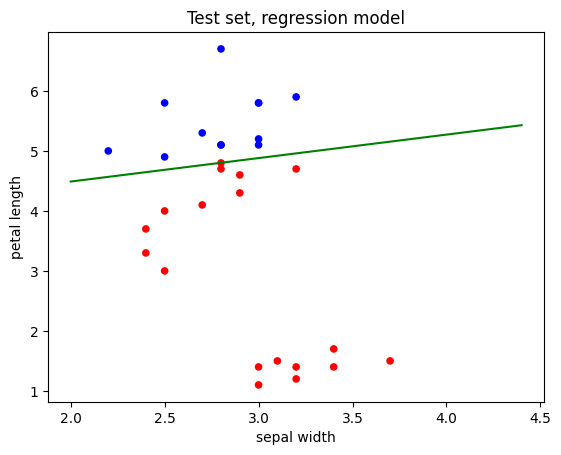

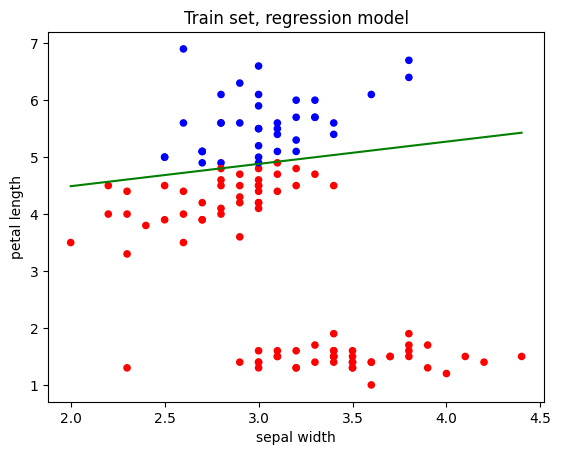

In [180]:
%matplotlib inline

col = {0:"r", 1:"b"}
ax = X_test.plot.scatter(x="sepal width", y="petal length", c=[col[e] for e in y_pred_reg])
ax.set_title("Test set, regression model")

bx = X_train.plot.scatter(x="sepal width", y="petal length", c=[col[e] for e in log_regress.predict(X_train)])
bx.set_title("Train set, regression model")

x1 = np.linspace(2, 4.4, 100)
def f(x1):
    b = log_regress.weights[0]
    w1 = log_regress.weights[1]
    w2 = log_regress.weights[2]
    x2 = - (b + w1*x1) / w2
    return x2

ax.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')
bx.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

In this case the data are less separable, so our classifier have more dificulty to correctly classify each point. But the generalization power of our model remain good;

**Question 8** : Compare the time complexity between these two algorithm

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

In this question we will only take interest in the fit method, the predict function being only computation.

For the **Perceptron** : In because there is a loop inside a while, in the worst case if the first misclassified $x$ is at the last index and we go through all the iteration until max_iteration. The complexity of the algorithm will be : $O(m_i \times N \times D)$, with $m_i$ the maximum number of iterations, N the number of samples and D the dimension of the dataset because $np.dot$ is $O(D)$.  

For the **Regression** : In this algorithm we have more constant operation but only one loop (the while), in the worst case if the algorithm don't find a valid solution until the end of the number max of iter ($m_i$), the complexity of this algorithm will be $O(m_i \times D \times N), this algorithm using a lot of numpy operation$.

Finally, the complexity of these algorithm depend on hyperparameter **$m_i$** for both. But the Regression algorithm depend on the hyperparameter **eps_conv** which is a learning rate.
So the complexity of the two model are quite similar, but the **Regression** using more $O(n)$ operation in the worst case it can be slower, so the choice of **eps_conv** is important for both the precision of a model and the performance of the algorithm.

**Question 9 :** Upload the eggyoke datasets. Use the perceptron and the logistic regression algorithms to solve the classification problem. Compute the empirical and generalization errors. Visualize the decision function (use the weights $w$). What happens? What could be done?

In [181]:
import pandas as pd
test_data = pd.read_csv("../data/eggyoke_testdata.csv")
X_test = test_data[["x_1", "x_2"]]
y_test = test_data["y"]

train_data = pd.read_csv("../data/eggyoke_traindata.csv")
X_train = train_data[["x_1", "x_2"]]
y_train = train_data["y"]

# To avoid this order too simple, I shuffle training data
X_train_shuffled = X_train.sample(frac=1, random_state=42)
y_train_shuffled = y_train.loc[X_train_shuffled.index]

*Data vizualisation*

<Axes: xlabel='x_1', ylabel='x_2'>

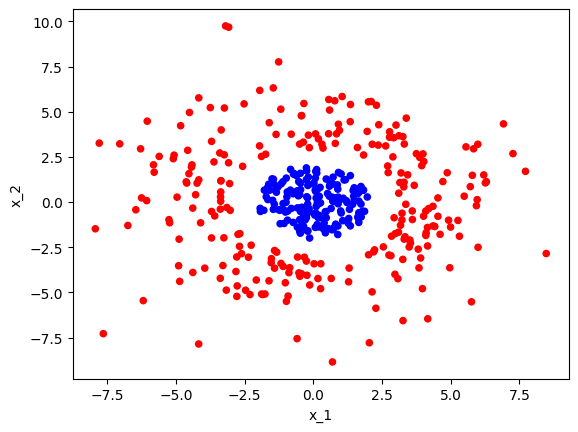

In [182]:
%matplotlib inline
X_concat = pd.concat((X_test, X_train)).reset_index(drop=True)
y_concat = pd.concat((y_test, y_train)).reset_index(drop=True)
col = {-1:"r", 1:"b"}
X_concat.plot.scatter(x='x_1', y='x_2', c=[col[e] for e in y_concat])

**Perceptron**

In [183]:
from sklearn.metrics import hinge_loss, zero_one_loss

model_perc = Perceptron(max_iter=100)
print("Weights pre-training", model_perc.weights, "bias pre-training", model_perc.bias)
model_perc.fit(X_train_shuffled.to_numpy(), y_train_shuffled.values)
print("Weights pre-training", model_perc.weights, "bias post-training", model_perc.bias)
y_pred_perc = model_perc.predict(X_test)

Weights pre-training [0. 0.] bias pre-training 0
Weights pre-training [-3.41746022  1.37000594] bias post-training -3


In [184]:
empirical_error = hinge_loss(model_perc.predict(X_train_shuffled), y_train_shuffled)
generalization_error = zero_one_loss(y_pred_perc, y_test)

print("empirical_error", empirical_error)
print("generalization_error", generalization_error)

empirical_error 1.1142857142857143
generalization_error 0.5592417061611374


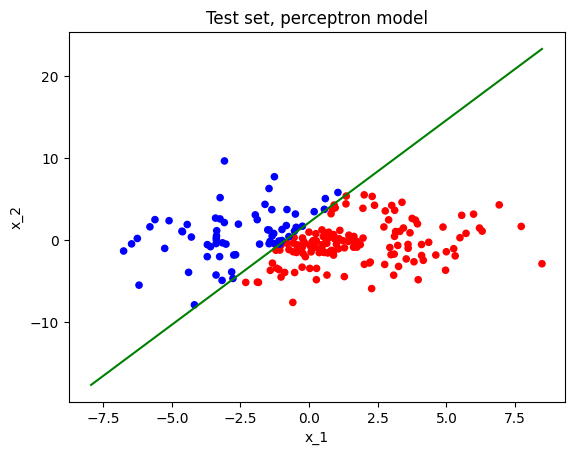

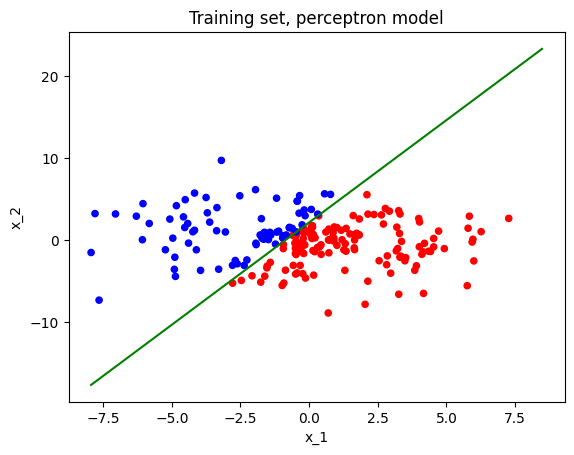

In [185]:
%matplotlib inline

x1_min_train = X_train["x_1"].min()
x1_max_train = X_train["x_1"].max()
x1_min_test = X_test["x_1"].min()
x1_max_test = X_test["x_1"].max()

x1_min = min(x1_min_train, x1_min_test)
x1_max = max(x1_max_train, x1_max_test)

col = {-1:"r", 1:"b"}
ax = X_test.plot.scatter(x="x_1", y="x_2", c=[col[e] for e in y_pred_perc])
ax.set_title("Test set, perceptron model")

bx = X_train_shuffled.plot.scatter(x="x_1", y="x_2", c=[col[e] for e in model_perc.predict(X_train_shuffled)])
bx.set_title("Training set, perceptron model")

x1 = np.linspace(x1_min, x1_max, 100)
def f(x1):
    b = model_perc.bias
    w1 = model_perc.weights[0]
    w2 = model_perc.weights[1]
    x2 = - (b + w1*x1) / w2
    return x2

ax.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')
bx.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

We know the perceptron, try to separate the data in two equal part, so in this case of no linearly separable data the model cut through the middle of the data, misclassifying a lot.

**Regression**

In [186]:
y_train_regress_eggyoke = y_train_shuffled.replace(-1, 0)
y_test_regress_eggyoke = y_test.replace(-1, 0)

In [187]:
log_regress = Logistic_Regression(eps_conv=0.0000000001)
print("Weights pre-training", log_regress.weights, "bias", log_regress.bias)
log_regress.fit(X_train_shuffled.to_numpy(), y_train_regress_eggyoke.values)
print("Weights pre-training", log_regress.weights)
y_pred_regression = log_regress.predict(X_test)

Weights pre-training [0. 0.] bias [0.]


Solution found after 4 iterations.
Weights pre-training [-0.34847551  0.01189687  0.04001102]


In [188]:
from sklearn.metrics import log_loss, zero_one_loss


empirical_error = log_loss(y_train_regress_eggyoke, log_regress.predict(X_train_shuffled))
generalization_error = zero_one_loss(y_pred_regression, y_test_regress_eggyoke)

print("empirical_error", empirical_error)
print("generalization_error", generalization_error)

empirical_error 15.104007134487187
generalization_error 0.4123222748815166


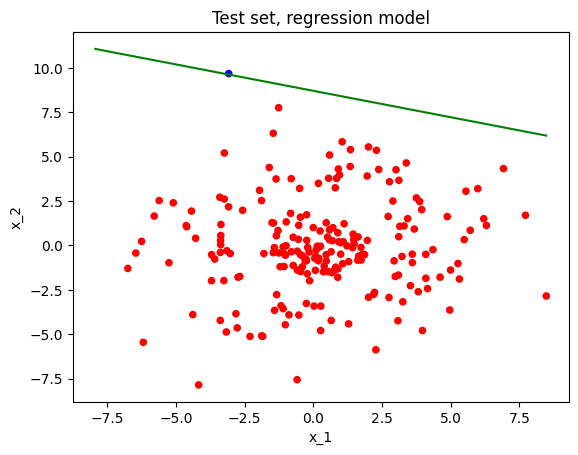

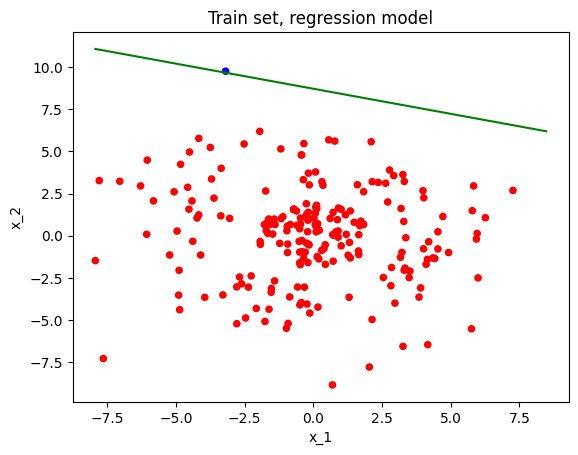

In [189]:
%matplotlib inline

x1_min_train = X_train["x_1"].min()
x1_max_train = X_train["x_1"].max()
x1_min_test = X_test["x_1"].min()
x1_max_test = X_test["x_1"].max()

x1_min = min(x1_min_train, x1_min_test)
x1_max = max(x1_max_train, x1_max_test)

col = {0:"r", 1:"b"}
ax = X_test.plot.scatter(x="x_1", y="x_2", c=[col[e] for e in y_pred_regression])
ax.set_title("Test set, regression model")

bx = X_train_shuffled.plot.scatter(x="x_1", y="x_2", c=[col[e] for e in log_regress.predict(X_train_shuffled)])
bx.set_title("Train set, regression model")

x1 = np.linspace(x1_min, x1_max, 100)
def f(x1):
    b = log_regress.weights[0]
    w1 = log_regress.weights[1]
    w2 = log_regress.weights[2]
    x2 = - (b + w1*x1) / w2
    return x2

ax.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')
bx.plot(x1, f(x1), color='green', linestyle='-', label='Boundary function')

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

We can see with this dataset the result are not that good. The main reason is because we try to solve a non linear problem with linear model. In this dataset, contrary to the iris dataset, the data are not linearly separable. So our classic linear model can't classify this effectively.

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

One solution to solve this classification problem could be to use an SVM model with a kernel which could be mapp my features into a higher dimension space. Because the class 2 data are close to the center and the class 1 data are far from it. In this case, using a polynomial kernel could be a good solution, such that : 
$$ k(x_1, x_2) = (x_1 * x_2)^2$$
This will separate the data close from the center to the one more spread out.